In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob

In [30]:
def mW_to_dBm(pwr_mW):
    return 10*np.log10(pwr_mW)

def dBm_to_mW(pwr_dBm):
    return 10**(pwr_dBm/10)

In [48]:
filenames = glob.glob("/home/polocalc/Documents/lab_test_scripts/diode_responsivity/2025_02_20_12_23_21_92.0GHz/Voltage_sweep/*V.txt")

att_tens = np.zeros(len(filenames))
t = np.zeros(len(filenames),dtype=object)
pwr = np.zeros(len(filenames),dtype=object)
adc = np.zeros(len(filenames),dtype=object)

for fn,i in zip(filenames,range(len(filenames))):
    att_tens[i] = float(fn.split("/")[-1].split("V")[0])
    t[i],pwr[i],adc[i] = np.loadtxt(fn,skiprows=4,unpack=True)
    
# sort for the attenuator tension
t = t[np.argsort(att_tens)]
pwr = pwr[np.argsort(att_tens)]
adc = adc[np.argsort(att_tens)]
att_tens = np.sort(att_tens)

In [49]:
# take the median of the adc, the mean of the pwr and see the delta_p and delta_V
avg_pwr = np.zeros(len(att_tens))
med_adc = np.zeros(len(att_tens))
std_pwr = np.zeros(len(att_tens))
delta_adc = np.zeros(len(att_tens))

for i in range(len(att_tens)):
    avg_pwr[i] = np.average(pwr[i])
    std_pwr[i] = np.std(pwr[i])
    med_adc[i] = np.median(adc[i])
    delta_adc[i] = abs(np.max(adc[i]) - np.min(adc[i]))

Text(0, 0.5, 'adc tension [mV]')

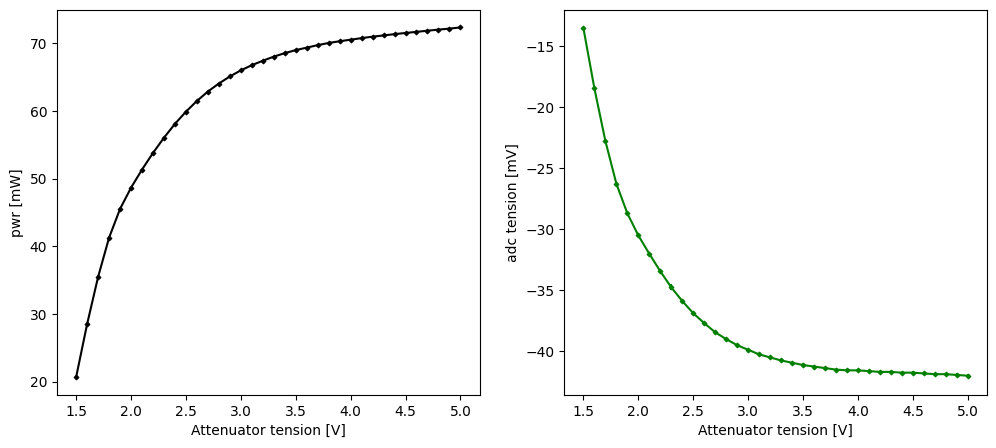

In [50]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(12,5))

ax[0].scatter(att_tens,avg_pwr,marker='D',s=5,color='black')
ax[0].errorbar(att_tens,avg_pwr,yerr=std_pwr,color='black')
ax[0].set_xlabel('Attenuator tension [V]')
ax[0].set_ylabel('pwr [mW]')

ax[1].scatter(att_tens,med_adc,color='green',marker='D',s=5)
ax[1].errorbar(att_tens,med_adc,yerr=delta_adc,color='green')
ax[1].set_xlabel('Attenuator tension [V]')
ax[1].set_ylabel('adc tension [mV]')

Text(0.5, 1.0, 'Diode responsivity')

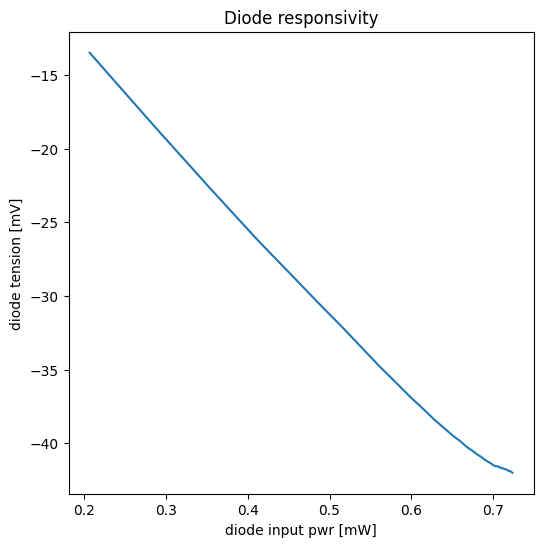

In [51]:
# convert the output power in dBm and correct for the directional coupler:
avg_pwr_dBm = mW_to_dBm(avg_pwr)
pwr_dBm_diode = avg_pwr_dBm - 20 # taking the nominal value from datasheet but the characterization is neeeded.

# move back to mW
pwr_diode = dBm_to_mW(pwr_dBm_diode)

# plot the responsivity:
fig = plt.figure(figsize=(6,6))
plt.plot(pwr_diode,med_adc)
plt.xlabel('diode input pwr [mW]')
plt.ylabel('diode tension [mV]')
plt.title('Diode responsivity')